In [1]:
%cd /mnt/home/zzhang/ceph/CHARM-AlternativeSplicing

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import random
plt.style.use(['science', 'no-latex'])

from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

%run ./notebook/navy_utils.py $DATA_VER $PCS_TO_INCL $USE_RE

navy_utils.py data-V7 ['PC0', 'PC6'] True


In [4]:
def pca_and_linear_fit(x_, data_, plot=False, save_fn=None):
    data = data_.copy()
    d = scale(x_, with_std=False)
    pca = PCA().fit_transform(d)
    data['PC1'] = pca[:,0]
    data['PC2'] = pca[:,1]
    mod = SVC(kernel='linear').fit(data[['PC1', 'PC2']], data['echo_test_diagnosis'])
    #score = mod.score(data[['PC1', 'PC2']], data['echo_test_diagnosis'])
    pred = mod.predict(data[['PC1', 'PC2']])
    acc = np.mean(pred==data['echo_test_diagnosis'])
    ppa = np.mean(pred[data['echo_test_diagnosis']=='pos']=='pos')
    npa = np.mean(pred[data['echo_test_diagnosis']=='neg']=='neg')
    score = {'acc':acc, 'ppa':ppa, 'npa':npa}
    if plot is True:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        ax = sns.scatterplot(
            x = 'PC1',
            y = 'PC2',
            hue = 'echo_test_diagnosis',
            hue_order=['pos', 'neg'],
            palette=['red', 'turquoise'],
            data=data,
            ax=ax
        )
        ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
        ax.set_title("Acc=%.3f" % acc)

        DecisionBoundaryDisplay.from_estimator(
            mod, data[['PC1', 'PC2']], alpha=0.2, ax=ax, response_method="predict",
            cmap = matplotlib.colors.ListedColormap(["seagreen", "pink"])
        )
        if save_fn is not None:
            fig.savefig(save_fn)
    return score

['ATP6V0B_longP', 'ATP6V0B_shortP', 'EPSTI1_longP', 'EPSTI1_shortP', 'GALNS_longP', 'GALNS_shortP', 'HMGN2_longP', 'HMGN2_shortP', 'IGLL5_longP', 'IGLL5_shortP', 'IQSEC1_longP', 'IQSEC1_shortP', 'KIF22_longP', 'KIF22_shortP', 'KY_longP', 'KY_shortP', 'LILRB2_longP_A3', 'LILRB2_longP_C3', 'LILRB2_shortP_B3', 'LILRB2_shortP_D3', 'LRRK1_longP', 'LRRK1_shortP', 'LST1_longP_A4', 'LST1_longP_C4', 'LST1_longP_E4', 'LST1_longP_G3', 'LST1_shortP_B4', 'LST1_shortP_D4', 'LST1_shortP_F4', 'LST1_shortP_H3', 'MRPS22_longP', 'MRPS22_shortP', 'PALM2AKAP2_longP', 'PALM2AKAP2_shortP', 'PHOSPHO1_longP_C5', 'PHOSPHO1_longP_E5', 'PHOSPHO1_shortP_D5', 'PHOSPHO1_shortP_F5', 'RILP_longP', 'RILP_shortP', 'RIN2_longP', 'RIN2_shortP', 'RPS3A_longP', 'RPS3A_shortP', 'SESN3_longP', 'SESN3_shortP', 'SNHG32_longP', 'SNHG32_shortP', 'TUBA8_longP', 'TUBA8_shortP', 'U91328.1_longP', 'U91328.1_shortP', 'ZFYVE26_longP', 'ZFYVE26_shortP']


{'acc': 0.9838709677419355, 'ppa': 0.967741935483871, 'npa': 1.0}

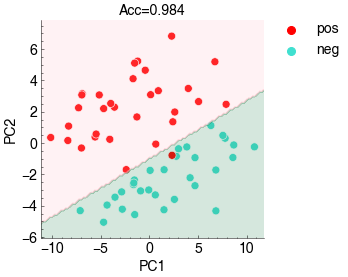

In [5]:
probe_data = pd.read_table("data-V7/fluidigm/Fluidigm.DAS.data.txt")
col_ind = [x for x in probe_data.columns if len(x.split('_')) > 1 and x.split('_')[1] in ('longP', 'shortP')]
print(col_ind)
df = probe_data[col_ind]


das_score = pca_and_linear_fit(df, probe_data, plot=True, save_fn="./data-V7/fluidigm/01-das.pdf")
das_score

In [6]:
gr_data = pd.read_table("./data-V7/fluidigm/Fluidigm_data.DEG.data.txt", index_col=0)
gr_meta = pd.read_table("./data-V7/fluidigm/Fluidigm_data.DEG.cohort.txt", index_col=0)

{'acc': 0.8617021276595744,
 'ppa': 0.8150470219435737,
 'npa': 0.8960739030023095}

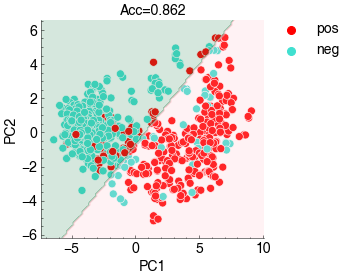

In [7]:
# total gene expression PCR; with multiple samples from one subject
pca_and_linear_fit(gr_data, gr_meta, plot=True)

{'acc': 0.9018181818181819,
 'ppa': 0.8571428571428571,
 'npa': 0.9358974358974359}

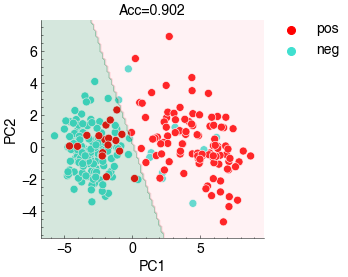

In [8]:
# sample one sample from each subject pid
gr_meta_p = pd.concat([pid_df.sample(1, random_state=0) for _, pid_df in gr_meta.groupby('pid')])[['sid', 'echo_test_diagnosis']]

deg_score = pca_and_linear_fit(gr_data.loc[gr_meta_p.index], gr_meta_p, plot=True, save_fn="./data-V7/fluidigm/01-deg.pdf")
deg_score

In [9]:
print("ppa = %i/%i"% ((gr_meta_p['echo_test_diagnosis']=='pos').sum() * deg_score['ppa'], (gr_meta_p['echo_test_diagnosis']=='pos').sum()))
print("npa = %i/%i"% ((gr_meta_p['echo_test_diagnosis']=='neg').sum() * deg_score['npa'], (gr_meta_p['echo_test_diagnosis']=='neg').sum()))

ppa = 102/119
npa = 146/156


In [10]:
# matching n=31 vs 31 study
scores = []
for rs in trange(10000):
    gr_meta_s = pd.concat([
        gr_meta_p.query('echo_test_diagnosis=="neg"').sample(31, random_state=rs), 
        gr_meta_p.query('echo_test_diagnosis=="pos"').sample(31, random_state=rs)])
    scores.append(
        pca_and_linear_fit(gr_data.loc[gr_meta_s.index], gr_meta_s, plot=False)['acc']
    )

100%|██████████| 10000/10000 [01:33<00:00, 106.40it/s]


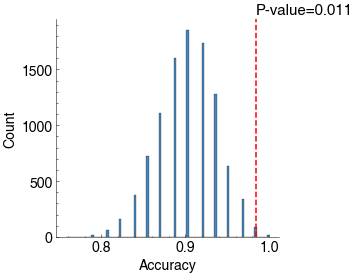

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax = sns.histplot(scores)
ax.axvline(das_score['acc'], color="red", ls="--")
ax.text(das_score['acc'], 2000, "P-value=%.3f" % np.mean(np.array(scores)>=das_score['acc']), fontsize=15)
ax.set_xlabel('Accuracy')
fig.savefig("./data-V7/fluidigm/02-das_permute.pdf")